In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import GPy
from matplotlib.colors import TwoSlopeNorm
from GPy.util.multioutput import ICM


In [3]:
def outcome_model(x, a, sd=1):
    """
    x: 1D array [x1, x2]
    a: 0 or 1 (control vs treatment)
    sd: noise standard deviation
    Returns: scalar outcome
    """
    x1, x2 = x
    base = (3/4)*np.exp(-((9*x1-2)**2)/4 -((9*x2-2)**2)/4) \
         + (3/4)*np.exp(-((9*x1+1)**2)/49 -((9*x2+1)**2)/10)
    treat_effect = (1/2)*a*np.exp(-((9*x1-7)**2)/4 -((9*x2-3)**2)/4) \
                  - (1/5)*a*np.exp(-((9*x1-4)**2) -((9*x2-7)**2))
    noise = np.random.normal(0, sd)
    return base + treat_effect + noise

def covariate_model(n):
    """Generate n covariates in [0,1]^2."""
    return np.random.uniform(0, 1, (n, 2))

def evaluate_performance(est, true):
    """
    Computes bias and RMSE.
    """
    bias = np.mean(est - true)
    rmse = np.sqrt(np.mean((est - true)**2))
    return bias, rmse

def plot_heatmap_single(data, title, X1, X2):
    """
    Plot a single heatmap of data.
    data: 2D array shaped as X1, X2
    X1, X2: meshgrid arrays
    """
    plt.figure(figsize=(6,5))
    levels = 25
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    vmin, vmax = data.min(), data.max()
    vcenter = 0.5*(vmin+vmax)
    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    c = plt.contourf(X1, X2, data, levels=levels, cmap=cmap, norm=norm)
    plt.colorbar(c, label="Value")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_heatmaps_side_by_side(data1, title1, data2, title2, X1, X2):
    """
    Plot two contourf heatmaps side by side for comparison.
    data1, data2: 2D arrays of shape (n, n) matching X1, X2 shape
    X1, X2: meshgrid arrays for contour plotting
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    levels = 25
    cmap = sns.color_palette("coolwarm", as_cmap=True)

    vmin = min(data1.min(), data2.min())
    vmax = max(data1.max(), data2.max())
    vcenter = 0.5 * (vmin + vmax)
    norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

    c1 = axes[0].contourf(X1, X2, data1, levels=levels, cmap=cmap, norm=norm)
    fig.colorbar(c1, ax=axes[0], label="Value")
    axes[0].set_xlabel("X1")
    axes[0].set_ylabel("X2")
    axes[0].set_title(title1)

    c2 = axes[1].contourf(X1, X2, data2, levels=levels, cmap=cmap, norm=norm)
    fig.colorbar(c2, ax=axes[1], label="Value")
    axes[1].set_xlabel("X1")
    axes[1].set_ylabel("X2")
    axes[1].set_title(title2)

    plt.tight_layout()
    plt.show()


In [4]:

n_grid = 50
x = np.linspace(0, 1, n_grid)
X1, X2 = np.meshgrid(x, x)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])

X_grid.shape

(2500, 2)

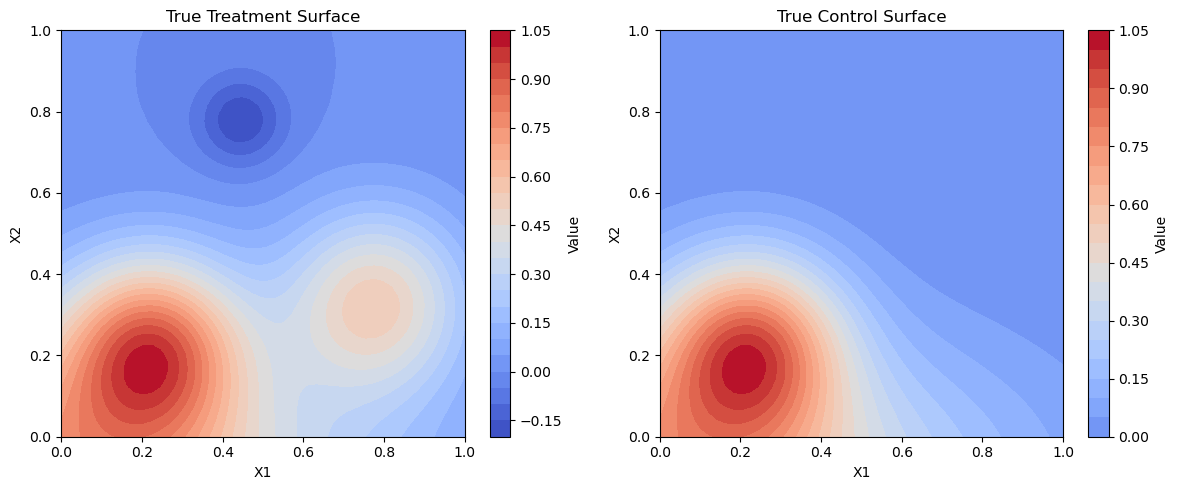

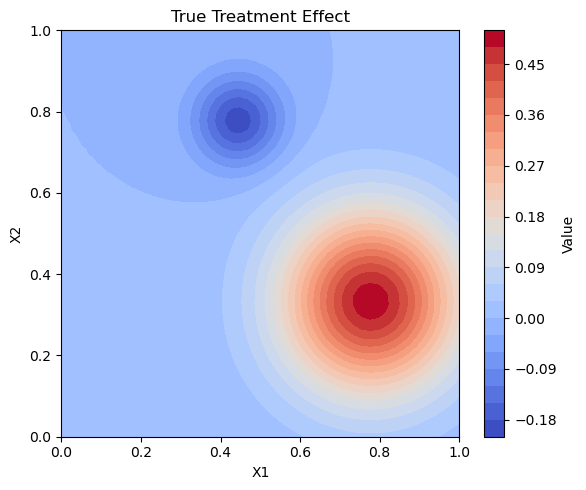

In [5]:

# True Potential Outcomes
Y_treatment_true = np.array([outcome_model(xi, 1, sd=0) for xi in X_grid])
Y_control_true = np.array([outcome_model(xi, 0, sd=0) for xi in X_grid])
TE_true = Y_treatment_true - Y_control_true

Y_treatment_true_reshaped = Y_treatment_true.reshape(X1.shape)
Y_control_true_reshaped = Y_control_true.reshape(X1.shape)
TE_true_reshaped = TE_true.reshape(X1.shape)

plot_heatmaps_side_by_side(Y_treatment_true_reshaped, "True Treatment Surface",
                           Y_control_true_reshaped, "True Control Surface",
                           X1, X2)

plot_heatmap_single(TE_true_reshaped, "True Treatment Effect", X1, X2)


In [7]:

# Observed data
n_train = 300
X_train = covariate_model(n_train)
A_train = np.random.binomial(1, 0.5, size=n_train)
Y_train = np.array([outcome_model(xi, ai, sd=0.1) for xi, ai in zip(X_train, A_train)])

X_control = X_train[A_train == 0]
Y_control = Y_train[A_train == 0].reshape(-1, 1)

X_treatment = X_train[A_train == 1]
Y_treatment = Y_train[A_train == 1].reshape(-1, 1)

def fit_multioutput_gp(X_list, Y_list):
    X_with_output_list = []
    for i, (X_part, Y_part) in enumerate(zip(X_list, Y_list)):
        out_idx = np.full((X_part.shape[0], 1), i, dtype=int)
        X_with_output = np.hstack([X_part, out_idx])
        X_with_output_list.append(X_with_output)
        
    # base_kernel = GPy.kern.RBF(input_dim=2, variance=1.0, lengthscale=1.0)
    # # Coregionalize expects input_dim=1 since it's indexing outputs
    # coreg = GPy.kern.Coregionalize(input_dim=1, output_dim=len(X_list), rank=rank)
    # multi_kern = base_kernel * coreg

    # model = GPy.models.GPCoregionalizedRegression(X_with_output_list, Y_list, kernel=multi_kern)
    # model.optimize(messages=False, max_f_eval=1000)
    
    # ICM kernel for correct handling of multi-output
    num_outputs = len(X_list)
    rbf = GPy.kern.RBF(input_dim=2, variance=1.0, lengthscale=1.0)
    icm = ICM(input_dim=2, num_outputs=num_outputs, kernel=rbf, W_rank=1)

    model = GPy.models.GPCoregionalizedRegression(X_with_output_list, Y_list, kernel=icm)
    model.optimize(messages=False, max_f_eval=1000)
    return model

model = fit_multioutput_gp([X_control, X_treatment], [Y_control, Y_treatment])

def predict_multioutput_gp(model, X_test):
    # Control predictions
    X_test_control = np.hstack([X_test, np.zeros((X_test.shape[0], 1), dtype=int)])
    pred_control = model.predict(X_test_control, Y_metadata={'output_index': np.zeros((X_test_control.shape[0],1),dtype=int)})

    # Treatment predictions
    X_test_treatment = np.hstack([X_test, np.ones((X_test.shape[0], 1), dtype=int)])
    pred_treatment = model.predict(X_test_treatment, Y_metadata={'output_index': np.ones((X_test_treatment.shape[0],1),dtype=int)})
    return pred_control, pred_treatment


 /Users/sudhamshu.hosamane/opt/anaconda3/envs/DoE_prj/lib/python3.10/site-packages/GPy/core/gp.py:85: UserWarning:Your kernel has a different input dimension 3 then the given X dimension 4. Be very sure this is what you want and you have not forgotten to set the right input dimenion in your kernel


In [8]:
pred_control, pred_treatment = predict_multioutput_gp(model, X_grid)
Y_control_pred = pred_control[0].flatten()
Y_treatment_pred = pred_treatment[0].flatten()

TE_pred = Y_treatment_pred - Y_control_pred

Y_control_pred_reshaped = Y_control_pred.reshape(X1.shape)
Y_treatment_pred_reshaped = Y_treatment_pred.reshape(X1.shape)
TE_pred_reshaped = TE_pred.reshape(X1.shape)

In [9]:
TE_pred_reshaped

array([[-0.0613469 , -0.05764088, -0.05319823, ...,  0.02696344,
         0.02158446,  0.01594901],
       [-0.05788456, -0.0538211 , -0.04903009, ...,  0.04589318,
         0.03922245,  0.03222527],
       [-0.05387102, -0.04946482, -0.04434516, ...,  0.06666885,
         0.05861298,  0.05015711],
       ...,
       [-0.08396422, -0.08782719, -0.09123448, ...,  0.0706509 ,
         0.07697656,  0.08267869],
       [-0.08506416, -0.08918445, -0.09284349, ...,  0.07622372,
         0.08219516,  0.08751282],
       [-0.08547916, -0.08980565, -0.09366938, ...,  0.08081184,
         0.08642083,  0.09135114]])

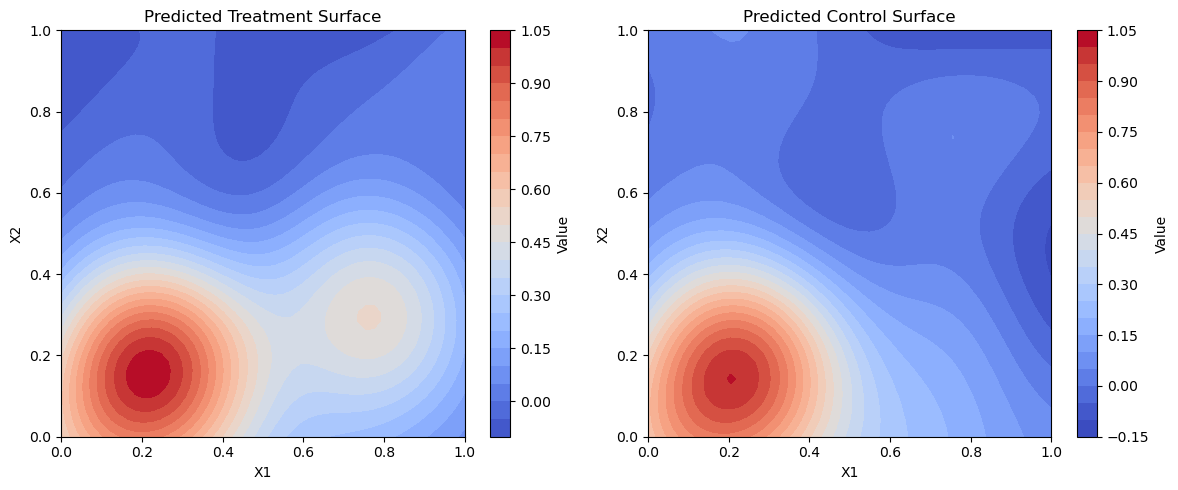

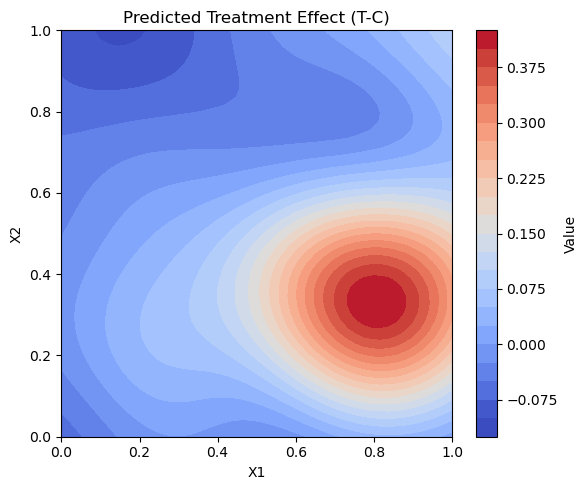

Treatment Effect - Bias: 0.0049, RMSE: 0.0447


In [10]:

plot_heatmaps_side_by_side(Y_treatment_pred_reshaped, "Predicted Treatment Surface",
                           Y_control_pred_reshaped, "Predicted Control Surface",
                           X1, X2)

plot_heatmap_single(TE_pred_reshaped, "Predicted Treatment Effect", X1, X2)

bias_TE, rmse_TE = evaluate_performance(TE_pred, TE_true)
print(f"Treatment Effect - Bias: {bias_TE:.4f}, RMSE: {rmse_TE:.4f}")
